# Lesson #4: Fitting

In this lesson, you will learn how to use the RooEFTMorphFunc to perform a fit to some pseudodata.

![what a fitting image!](https://media1.tenor.com/images/348aad33def25e419aae7f5c1f341648/tenor.gif?itemid=5323722 "what a fitting image")


As you have already seen, the morphing function mapping the parameter values to output distributions is very fast - much faster than any generator would be able to generate events! The reason for this is that all the complicated physics are pre-calculated and contained in the input histograms, of which the morphing only builds a linear combination. In fact, the computation of the morphing result is so quick that it effectively forms a contuinous model. It is even feasible to perform iterative optimizations (e.g. a likelihood fit) on the morphing function, which you will explore in this lesson.

## Setup files and samples

These are set up as before. The identifier is just a hook to specify the name in the file structure.

In [1]:
gSystem->Load("libRooLagrangianMorphing")


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

(int) 0


In [2]:
!wget https://www.nikhef.nl/~cburgard/downloads/RooLagrangianMorphingTutorial/inputs/vbfhwwlvlv_3d.root -nc

File ‘vbfhwwlvlv_3d.root’ already there; not retrieving.



In [3]:
std::string identifier("vbfWW"); // avaliable: ggfWW, vbfWW, vbfZZ, ggfZZ, vbfMuMu 
std::string infilename("vbfhwwlvlv_3d.root"); // give the input file name here
std::string observable("twoSelJets/dphijj"); // name of the observable to be used (histogram name)

Once again all 15 VBF parameters are considered.

In [4]:
std::vector<std::string> samplelist = {"kAwwkHwwkSM0","kAwwkHwwkSM1","kAwwkHwwkSM10","","kAwwkHwwkSM11","kAwwkHwwkSM12","kAwwkHwwkSM13","kAwwkHwwkSM2","kAwwkHwwkSM3","kAwwkHwwkSM4","kAwwkHwwkSM5","kAwwkHwwkSM6","kAwwkHwwkSM7","kAwwkHwwkSM8","kAwwkHwwkSM9","kSM0"};
// these are the validation samples: "v0","v1","v2","v3","v4","v5","v6","v7","v8","v9"

push all the input samples in a RooArgList

In [5]:
RooArgList inputs;
for(auto const& sample: samplelist) {
    RooStringVar* v = new RooStringVar(sample.c_str(),sample.c_str(),sample.c_str());
    inputs.add(*v);
}

## setup predefined morphing function

As in excercise 2 we use a pre-implemented specialized class called "RooHCvbfWWMorphPdf", that already knows about the vertex structure of this process. So all you really need to do is change the call to the constructor of your morphing function. You will later learn how to implement the morphing for completely new physics processes and create new specialized classes like this one for the process of your choice.

In [6]:
RooLagrangianMorphPdf* morphfunc = new RooHCvbfWWMorphPdf(identifier.c_str(),identifier.c_str(),infilename.c_str(),observable.c_str(),inputs);

RooLagrangianMorphBase: a RooFit class for morphing physics distributions between configurations. authors:
   Lydia Brenner   (lbrenner@cern.ch)
   Carsten Burgard (cburgard@cern.ch)
   Katharina Ecker (kecker@cern.ch)
   Adam Kaluza     (akaluza@cern.ch)
please feel free to contact with questions and suggestions.


morph to the validation sample v1

In [7]:
std::string validationsample("v1");
morphfunc->setParameters(validationsample.c_str());
TH1* morphing = morphfunc->createTH1("morphing");

ERROR: parameter Lambda out of bounds: 0 < 900


## Read The Validation Histogram

We now retrieve the corresponding histogram of the validation sample from the same input file. 

In [8]:
TFile* file = TFile::Open(infilename.c_str(),"READ");
TFolder* folder = 0;
file->GetObject(validationsample.c_str(),folder);
TH1* validation = dynamic_cast<TH1*>(folder->FindObject(observable.c_str()));
validation->SetDirectory(NULL);
validation->SetTitle(validationsample.c_str());
file->Close();

## setup the fit

In order for this to work, we of course first need some pseudodata. For this, you can use one of the validation samples. This is especially useful because it will allow you to compare the nominal values of the parameters used in that sample with the ones that you will obtain from your fit. to obtain it, you can use the following line in C++:

```RooDataHist* target = RooEFTMorphFunc::makeDataHistogram(validation,morphfunc->getObservable(),"validation");```

or, similarly, in python:

```target = RooEFTMorphFunc.makeDataHistogram(validation,morphfunc.getObservable(),"validation")```

The following hints will help you understand the fit quickly:
- Since the fit has multiple parameters and the likelihood is not always well-behaved, it helps to start in the proximity of your known (or expected) values.
- Start off by calling "setParameters" to set the parameters of the validation sample you want to use as pseudodata.
- In order to give the fit something to do, you probably want to vary the parameters just a bit. You can do this by either manually setting their values using the `setParameter` method, or by adding a random fluctuation using the "randomizeParameters" method, which takes the number of standard deviations by which to randomize as an argument. By default, the standard deviations of the input paremeters are set to 0.001.
- You can also use the "setParameterConstant" method to freeze individual parameters before fitting.

![why wont you work?!](https://media3.giphy.com/media/l2Je6sbvJEn1W9OWQ/giphy.gif?cid=790b76115ca4e577384c4937326de004 "damn legos")

For the actual fit, you just need to retrieve the internal probability density function by calling the `getPdf` method, on which you can then call the standard Roofit method `fitTo`. Afterwards, you can all the RooEFTMorphFunc method `printParameters` to print to console the results of the fit.

You should also call the `createTH1` method one more time after performing the fit and plot the distribution obtained from the fit on the same canvas. Ideally, all three distributions - the validation, the result of morphing to the nominal parameter values and the fit result should be compatible!

In [9]:
RooDataHist* target = RooLagrangianMorphing::makeDataHistogram(validation,morphfunc->getObservable(),"validation"); // convert the target to a RooDataHist
morphfunc->setParameters(validationsample.c_str());
morphfunc->setParameterConstant("Lambda",true);
morphfunc->setParameterConstant("cosa",true);
morphfunc->randomizeParameters(2); // randomize the parameters by 2 standard deviations to give the fit something to do
morphfunc->printParameters();
morphfunc->getPdf()->fitTo(*target,RooFit::SumW2Error(true),RooFit::Optimize(false)); // run the fit
morphfunc->printParameters();
TH1* fitresult = morphfunc->createTH1("fit result");

cosa: 0.707107 (const)
Lambda: 1000 (const)
kSM: 2.82843 +0 -0 (-2.82843 - 2.82843)
kHaa: 0 (const)
kAaa: 0 (const)
kHza: 0 (const)
kAza: 0 (const)
kHzz: 0 (const)
kAzz: 0 (const)
kHdz: 0 (const)
kHww: -0.566961 +0 -0 (-9.69994 - 9.69994)
kAww: 8.82079 +0 -0 (-15.7624 - 15.7624)
kHdwR: 0 (const)
kHdwI: 0 (const)
kHda: 0 (const)
[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 kAww         8.82079e+00  1.00000e-02   -1.57624e+01  1.57624e+01
     2 kHww        -5.66961e-01  1.00000e-02   -9.69994e+00  9.69994e+00
     3 kSM          2.82843e+00  1.00000e-02   -2.82843e+00  2.82843e+00
 MINUIT WARNING IN PARAM DEF
 ============== STARTING VALUE IS AT LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE3 IS AT ITS UPPER ALLOWED LIMIT.
 MIN

cosa: 0.707107 (const)
Lambda: 1000 (const)
kSM: 1.44053 +0.0908571 -0 (-2.82843 - 2.82843)
kHaa: 0 (const)
kAaa: 0 (const)
kHza: 0 (const)
kAza: 0 (const)
kHzz: 0 (const)
kAzz: 0 (const)
kHdz: 0 (const)
kHww: -4.32934 +0.742074 -0 (-9.69994 - 9.69994)
kAww: 2.74753 +2.86886 -0 (-15.7624 - 15.7624)
kHdwR: 0 (const)
kHdwI: 0 (const)
kHda: 0 (const)


## Print the pretty plots!
we use the canvas created above and add legend in order to plot both histograms - the one obtained from the validation sample and the morphing prediction for the same parameter set and now the fit also.

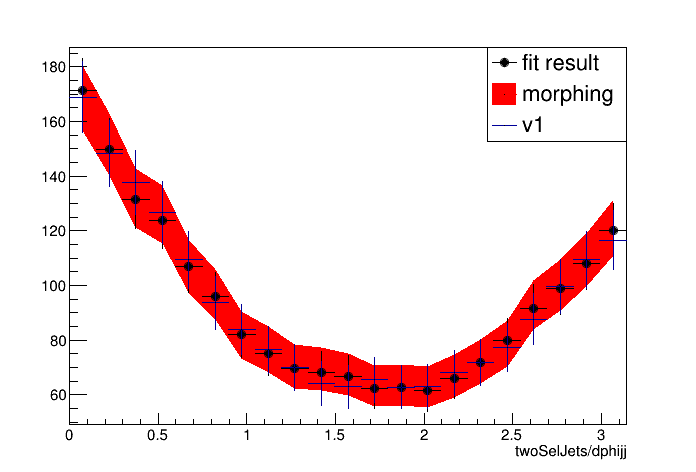

In [10]:
TCanvas* plot = new TCanvas("plot");
plot->cd();
gStyle->SetOptStat(0);
gStyle->SetOptTitle(0);
morphing->GetXaxis()->SetTitle(observable.c_str());
morphing->SetLineColor(kRed);
morphing->SetFillColor(kRed);
morphing->Draw("E3");
fitresult->SetLineColor(kBlack);
fitresult->SetMarkerColor(kBlack);
fitresult->SetMarkerStyle(20);
fitresult->Draw("PSAME");
validation->Draw("SAME");
TLegend* leg = new TLegend(0.7,0.7,0.9,0.9);
leg->AddEntry(fitresult);
leg->AddEntry(morphing);
leg->AddEntry(validation);
leg->Draw();
plot->Draw()

![ah that fit!](https://media2.giphy.com/media/xEECLnuSQWQes/giphy.gif?cid=790b76115ca4e6ae576c7654559d5694 "ah")

## Playground
- Use the `printParameters` method right after setting the parameters of your validation sample and compare the numbers to those obtained after the fit. Did you achieve closure?
- Like most complex fit models, it's easy to choose parameter settings in which the fit does either not converge or not find the right minimum. Try to get a feeling for how close to the target point you need to choose your initial values to make the fit converge to the correct minimum!
- You will quickly notice that the fit is much more sensitive to some parameters than it is to others. Which parameters are especially unstable?